In [11]:
# print version / should be 1.6.x
println(versioninfo())

# load centralized paths dictionary
using YAML
PATHS_FILE = "../../../PATHS.YML"
PATHS = YAML.load_file(PATHS_FILE);

"""
    load_path(keys::Vector{String}):String

Return the absolute path for a requested item within the nested PATHS dictionary.
"""
function loadpath(keys::Vector{String}):String
    # recusively assemble paths from keys
    requested_path = foldl((x, y) -> getindex(x, y), keys; init=PATHS)
    # rephrase abs path from relative paths to be platform independent.
    realpath(joinpath(splitdir(realpath(PATHS_FILE))[1], requested_path))
end;

Julia Version 1.6.6
Commit b8708f954a (2022-03-28 07:17 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i5-4260U CPU @ 1.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, haswell)
nothing


In [12]:
# we load the project path as it is used by CliMA Land v01 papers
using Pkg
PROJECT_PATH = loadpath(["EXTERNAL", "01_CLIMA_LAND_V01", "ROOT"])
Pkg.activate(PROJECT_PATH)


  Activating environment at `~/Desktop/island_in_the_sun/python/2022_04_lsm/ext_src/01_julia_land_v01/Land/Project.toml`


In [4]:
using BenchmarkTools
using CSV
using Chain
using DataFrames
using LaTeXStrings
using Plots
using Revise
using StatsPlots

# we define the gr₂ic backend as plotly
plotlyjs()

WebIO._IJuliaInit()

Plots.PlotlyJSBackend()

# First exploration of CliMA Land v0.1

For our emulator, we want to use the CliMA Land model (v0.1), as it has [some advantages](../../../docs/reporting/01_meetings_documentation.md#M05_climaland). Therefore, it is important to understand the model. Thus, we will install it and follow/disentangle the code of the trial. Later, we can change some parameters and see the response.

## Installation

I installed CliMA Land v0.1 following the instructions of its [README](https://github.com/CliMA/Land/blob/41f90baa90c5b8e761fdcce5005eebde2f42b26b/README.md).

The script `clima-land.jl` was stored in the cloned repository, the dataset`era5_2019_117_296_1X.csv` in our cache directory.

## Disentangling the wrapper

The wrapper of the tutorial should allow to run the LSM simulations for single points. To reproduce and alternate it, I will go through the code subsequently.

**This is the whole script:**

In [4]:
# load wrapper path and print its code
CL_WRAPPER_FILE = loadpath(["EXTERNAL", "01_CLIMA_LAND_V01", "WRAPPER"]);

open(CL_WRAPPER_FILE) do file
    println(read(file, String))
end

using LazyArtifacts

using CanopyLayers: BLUE, EVI, FourBandsFittingHybrid, NDVI, NIR, NIRv, NIRvES, RED, SIF_740, SIF_WL, SIF_fluxes!, canopy_fluxes!, canopy_geometry!, canopy_matrices!, fit_soil_mat!, short_wave!, soil_albedos
using DataFrames: DataFrame
using GriddingMachine: lat_ind, lon_ind
using Photosynthesis: AbstractPhotoModelParaSet, AirLayer, leaf_ETR!
using PkgUtility: numerical∫, read_csv, save_csv!
using PlantHydraulics: soil_p_25_swc, temperature_effects!
using SoilPlantAirContinuum: SPACMono, initialize_spac_canopy!, update_Cab!, update_LAI!, zenith_angle
using Statistics: mean
using StomataModels: BetaGLinearPsoil, CanopyLayer, ESMMedlyn, EmpiricalStomatalModel, GswDrive, gas_exchange!, gsw_control!, stomatal_conductance, update_leaf_TP!, β_factor
using UnPack: @unpack
using WaterPhysics: saturation_vapor_pressure


# function to create a SPAC node
create_spac(lat::FT, lon::FT) where {FT<:AbstractFloat} = (
    _soil_bnds = FT[0, -0.1, -0.35, -1, -3];
    _z_c::FT   = 

In [5]:
using GriddingMachine: lat_ind, lon_ind

In [6]:
# we also load it to have access to the functions
include(CL_WRAPPER_FILE); 

### Function per function

I will go through the functions one after the other:

#### `create_spac`

The CliMA Land model uses instances of soil plant air continua (a.k.a SPACs). The [SPACMono](https://yujie-w.github.io/SoilPlantAirContinuum.jl/stable/API/#SoilPlantAirContinuum.SPACMono) is the atomic 1D abstraction of a grid cell. It represents a single species of plant interacting with soil and atmosphere and has properties like:
- Root depth
- Canopy maximal height
- Longitude and Latitude
- Ground area
- Layers of Roots/Canopy
- Canopy water flux per ground area
- ...

The variable `soil_bnds` represents the discrete boundaries of soil layers (here 4 as used in [Wang, et al. (2022)](#wangModelingGlobalCarbon2022a), like in JULES) for different hydraulic parameters. It is used for soil hydraulic conductivity by [van Genuchten (1980)](#vangenuchtenClosedformEquationPredicting1980). One could use 6 or the 10 CLM layers published globally by [Dai, et al. (2019)](#daiGlobalHighResolutionData2019).

In short, this function builds an instance for a single model grid cell.

#### `query_data`

The trial uses a dataset for 26.5°N, 115.5°E in 2019. Its data is stored in `era5_2019_117_296_1X.csv`. This function helps to translate the temporal and spatial coordinates to the filename of the corresponding data and instantiates a SPAC for it.

#### `update_gsw!`

This function updates the stomatal conductance (instantiated within `CanopyLayer` object) for a timestep. Therefore, it uses a set of photosynthesis parameter (C3 or C4 dependent), the surrounding air conditions of the canopy (`AirLayer`), temperature difference, time interval and a correction factor.

#### `clima_land!` #1

Within the wrapper script, the core function is the `clima_land!` inplace simulation. It works on a `SPACMono` instance and stores the model outputs within a dataframe.

The function uses the input datasheet and iterates through each row (and days as float/FDOY)

In [7]:
CL_WRAPPER_CSVFILE = loadpath(["DATA", "TRIAL", "CLIMA_LAND", "WRAPPER_DATA"]);

df = CSV.read(CL_WRAPPER_CSVFILE, DataFrame);

In [8]:
withenv("COLUMNS" => 1000) do
    display(df[1:10,:])
end

10×22 DataFrame
 Row │ u10         v10       d2m      t2m      evavt        msdrswrf   msdwswrf  skt      stl1     stl2     stl3     stl4     sp             swvl1     swvl2     swvl3     swvl4     FDOY      WIND     RAD_DIF    RAD_DIR    VPD      
     │ Float64     Float64   Float64  Float64  Float64      Float64    Float64   Float64  Float64  Float64  Float64  Float64  Float64        Float64   Float64   Float64   Float64   Float64   Float64  Float64    Float64    Float64  
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ -0.244298   -2.68466  273.025  274.239  -4.163e-5      2.24389   10.2953  273.663  275.887  277.731  284.404  291.136      1.00036e5  0.458745  0.459198  0.450892  0.442369  0.341667  2.69576    8.05141    2.24389   55.615
   2 │ -0.292182   -2.59695  273.003  274.174  -1.6108e-6     7.27977   58.3956  274.384  275.535  277.703  284.38   291.13       1.00046e5  0.458485  0.45914   0.450883  0.442373  0.383333  2.61333   51.1159     7.27977   53.4656
   3 │ -0.213711   -2.68381  273.536  275.396  -3.09868e-6   46.4403   150.369   274.959  276.401  277.704  284.355  291.125      1.00085e5  0.458202  0.459061  0.450875  0.442372  0.425     2.6923   103.928     46.4403    89.8877
   4 │ -0.0344099  -2.88229  273.571  275.398  -4.46663e-6   60.6056   211.243   275.651  276.233  277.742  284.331  291.12   99987.0        0.457904  0.458969  0.450863  0.442373  0.466667  2.8825   150.638     60.6056    88.3688
   5 │  0.114259   -3.13434  273.468  275.289  -5.80835e-6   66.2457   229.438   276.802  276.265  277.813  284.307  291.114  99857.1        0.457579  0.458837  0.45084   0.442376  0.508333  3.13642  163.193     66.2457    87.4814
   6 │  0.219577   -3.23774  273.78   276.141  -7.11259e-6   64.8182   211.77    276.571  277.356  277.909  284.284  291.109  99709.5        0.457293  0.458717  0.450824  0.44238   0.55      3.24518  146.952     64.8182   117.727
   7 │  0.249901   -3.21085  273.758  276.263  -8.37186e-6  131.052    272.068   277.014  277.865  278.026  284.262  291.104  99656.8        0.457048  0.458578  0.450802  0.442381  0.591667  3.22056  141.017    131.052    125.305
   8 │  0.355791   -3.26196  273.571  276.075  -9.75855e-6   14.2745   104.613   277.08   278.021  278.148  284.24   291.098  99645.7        0.456806  0.458446  0.450779  0.442387  0.633333  3.28131   90.339     14.2745   123.83
   9 │  0.437916   -3.35342  273.611  275.675  -1.1134e-5     6.52928   75.756   276.293  277.816  278.254  284.219  291.093  99666.8        0.456684  0.458345  0.450763  0.442385  0.675     3.38189   69.2267     6.52928  100.821
  10 │  0.437212   -3.35704  273.386  275.598  -1.25769e-5    4.57193   35.0254  275.55   277.477  278.332  284.2    291.087  99714.9        0.456635  0.458275  0.450755  0.442389  0.716667  3.38539   30.4534     4.57193  107.06

The used variables are:

These variables need to given for each timepoint to make GPP simulations for a timewindow. I do not think extrapolation is possible.

The simulation is only run if diffuse and direct radiation are higher than a threshold of $10 W m^{-2}$. Why?

In [9]:
gdf = groupby(df, :FDOY);
select(df, [:FDOY,:RAD_DIF, :RAD_DIR], [:RAD_DIF, :RAD_DIR] => ((a,b) -> a+b) => :rad_sum, renamecols=false) |>
    x -> display(x[1:20,:])

20×4 DataFrame
 Row │ FDOY      RAD_DIF    RAD_DIR     rad_sum   
     │ Float64   Float64    Float64     Float64   
─────┼────────────────────────────────────────────
   1 │ 0.341667    8.05141    2.24389    10.2953
   2 │ 0.383333   51.1159     7.27977    58.3956
   3 │ 0.425     103.928     46.4403    150.369
   4 │ 0.466667  150.638     60.6056    211.243
   5 │ 0.508333  163.193     66.2457    229.438
   6 │ 0.55      146.952     64.8182    211.77
   7 │ 0.591667  141.017    131.052     272.068
   8 │ 0.633333   90.339     14.2745    104.613
   9 │ 0.675      69.2267     6.52928    75.756
  10 │ 0.716667   30.4534     4.57193    35.0254
  11 │ 0.758333    3.69566    0.020468    3.71612
  12 │ 0.8         0.0        0.0         0.0
  13 │ 0.841667    0.0        0.0         0.0
  14 │ 0.883333    0.0        0.0         0.0
  15 │ 0.925       0.0        0.0         0.0
  16 │ 0.966667    0.0        0.0         0.0
  17 │ 1.00833     0.0        0.0         0.0
  18 │ 1.05        0.0        0.0         0.0
  19 │ 1.09167     0.0        0.0         0.0
  20 │ 1.13333     0.0        0.0         0.0

... because most of the radiation values during daytime are higher. Thus, it is a good threshold for skipping unneccessary computations.

```
clima_land!(node::SPACMono{FT}, df::DataFrame; hyper::Bool = true) where {FT<:AbstractFloat} = (
    # 0.1 unpack data
    @unpack angles, can_opt, can_rad, canopy_rt, envirs, f_SL, ga, in_rad, latitude, leaves_rt, n_canopy, photo_set, plant_hs, plant_ps, rt_con, rt_dim, soil_opt, stomata_model, wl_set = node;
    @unpack nAzi, nIncl = canopy_rt;
    _in_rad_bak = deepcopy(in_rad);
    _in_dir     = numerical∫(_in_rad_bak.E_direct, wl_set.dWL) / 1000;
    _in_dif     = numerical∫(_in_rad_bak.E_diffuse, wl_set.dWL) / 1000;
    _nSL        = nAzi * nIncl;
    _beta_g     = BetaGLinearPsoil{FT}();

    # iterate through the weather data
    _chl_last = -9999;
    _lai_last = -9999;

    # soil albedo method is FourBandsFittingHybrid
    _method = FourBandsFittingHybrid();
```
<p style="text-align:right;color:red">The code iterates thorugh all days of the input data.</p> 

```
# for _i in eachindex(df.FDOY)
    for _i in eachindex(df.FDOY)
        _f_H₂O::FT  = 0;
        _f_CO₂::FT  = 0;
        _f_GPP::FT  = 0;
        _f_APAR::FT = 0; 
        _e_dir::FT  = df.RAD_DIR[_i];
        _e_dif::FT  = df.RAD_DIF[_i];
```

<p style="text-align:right;color:red">For performance reason parameters are only updated if they change.</p> 

```
        # if total LAI changes, update LAI
        if !isnan(df.LAI[_i]) && (df.LAI[_i] != _lai_last)
            update_LAI!(node, df.LAI[_i]);
            _lai_last = df.LAI[_i];
        end;
```

<p style="text-align:right;color:red">The carotinoid content of all leafs is estimated to be 1/7th of the chlorophyl content (Croft et al., 2020).</p> 

```
        # if chlorophyll content changes, update Cab and Vcmax
        if !isnan(df.Chlorophyll[_i]) && (df.Chlorophyll[_i] != _chl_last)
            for _leaf in node.leaves_rt
                    _leaf.Car = df.Chlorophyll[_i] / 7; 
            end;
            update_Cab!(node, df.Chlorophyll[_i]);
            _chl_last = df.Chlorophyll[_i];
        end;
```

<p style="text-align:right;color:red">As discussed above simulations are run if radiation for photosynthesis is above a threshold.</p> 

```        # if total in coming radiation > 10 W m⁻² run the simulation
        if _e_dir + _e_dif > 10
            # update soil water matrices per layer
```

<p style="text-align:right;color:red">They update soil hydaulics for the plants. 3 basic types (grass, palm, tree) are available.</p> 

```  
            _svc_1 = plant_hs.roots[1].sh;
            _svc_2 = plant_hs.roots[2].sh
            _svc_3 = plant_hs.roots[3].sh
            _svc_4 = plant_hs.roots[4].sh
            _swc_1 = max(_svc_1.Θr+FT(0.001), FT(df.swvl1[_i]));
            _swc_2 = max(_svc_2.Θr+FT(0.001), FT(df.swvl2[_i]));
            _swc_3 = max(_svc_3.Θr+FT(0.001), FT(df.swvl3[_i]));
            _swc_4 = max(_svc_4.Θr+FT(0.001), FT(df.swvl4[_i]));
```

<p style="text-align:right;color:red">They compute relative soil water content using <code>Land.PlantHydraulics.soil_p_25_swc</code>.</p> 

```  
            _p_1   = soil_p_25_swc(_svc_1, _swc_1);
            _p_2   = soil_p_25_swc(_svc_2, _swc_2);
            _p_3   = soil_p_25_swc(_svc_3, _swc_3);
            _p_4   = soil_p_25_swc(_svc_4, _swc_4);
            plant_hs.roots[1].p_ups = _p_1;
            plant_hs.roots[2].p_ups = _p_2;
            plant_hs.roots[3].p_ups = _p_3;
            plant_hs.roots[4].p_ups = _p_4;

```

<p style="text-align:right;color:red">Albedo of soil is calculated as reflection is important for radiation. Here the variable use is a bit confusing, as unpacked and packed <code>soil_opt</code> are used in a mix.</p> 

```  
            # update soil albedo
            if hyper
                fit_soil_mat!(node.soil_opt, node.wl_set, _swc_1, _method);
            else
                # TODO make this a method of fit_soil_mat!
                _ρ_PAR,_ρ_NIR = soil_albedos(node.soil_opt.color, _swc_1, true);
                node.soil_opt.ρ_SW .= _ρ_NIR;
                node.soil_opt.ρ_SW[node.wl_set.iPAR] .= _ρ_PAR;
                node.soil_opt.ρ_SW_SIF .= node.soil_opt.ρ_SW[node.wl_set.iWLF];
                node.soil_opt.ε_SW .= 1 .- node.soil_opt.ρ_SW;
            end;


```

<p style="text-align:right;color:red">They compute the photosynthetically relevant readiation and simulate some radiation.</p> 

``` 
            # update PAR related information
            _e_dir = df.RAD_DIR[_i];
            _e_dif = df.RAD_DIF[_i];
            in_rad.E_direct  .= _in_rad_bak.E_direct  .* _e_dir ./ _in_dir;
            in_rad.E_diffuse .= _in_rad_bak.E_diffuse .* _e_dif ./ _in_dif;
            angles.sza = min(88, zenith_angle(latitude, FT(df.FDOY[_i])));
            canopy_geometry!(canopy_rt, angles, can_opt, rt_con);
            canopy_matrices!(leaves_rt, can_opt);
            short_wave!(canopy_rt, can_opt, can_rad, in_rad, soil_opt, rt_con);
            canopy_fluxes!(canopy_rt, can_opt, can_rad, in_rad, soil_opt, leaves_rt, wl_set, rt_con);

```

<p style="text-align:right;color:red">For all canopy level, the relative leaf area is computed.</p> 

``` 
            # calculate leaf level flux per canopy layer
            for _i_can in 1:n_canopy
                _iPS = plant_ps[_i_can];
                _iRT = n_canopy + 1 - _i_can;

                # calculate the fraction of sunlit and shaded leaves
                _f_view = (can_opt.Ps[_iRT] + can_opt.Ps[_iRT+1]) / 2;
                for iLF in 1:_nSL
                    _iPS.APAR[iLF] = can_rad.absPAR_sunCab[(_iRT-1)*_nSL+iLF] * FT(1e6);
                    _iPS.LAIx[iLF] = _f_view * f_SL[iLF];
                end;
                _iPS.APAR[end] = can_rad.absPAR_shadeCab[_iRT] * FT(1e6);
                _iPS.LAIx[end] = 1 - _f_view;
            end;
        end;

```

<p style="text-align:right;color:red">Finally the fluxes between leaf levels and atmosoil are computed for all of them</p> 

``` 
        # calculate leaf level flux per canopy layer
        for _i_can in 1:n_canopy
            _iEN = envirs[_i_can];
            _iHS = plant_hs.leaves[_i_can];
            _iPS = plant_ps[_i_can];

            # update environmental conditions
            _iEN.t_air = df.t2m[_i];
            _iEN.p_atm = df.sp[_i];
            _iEN.p_a   = _iEN.p_atm * df.CO2[_i] * 1e-6;
            _iEN.p_O₂  = _iEN.p_atm * 0.209;
            _iEN.p_sat = saturation_vapor_pressure(_iEN.t_air);
            _iEN.vpd   = df.VPD[_i];
            _iEN.p_H₂O = _iEN.p_sat - _iEN.vpd;
            _iEN.RH    = _iEN.p_H₂O / _iEN.p_sat;
            _iEN.wind  = df.WIND[_i];

            # prescribe leaf temperature
            _iPS.T = max(df.t2m[_i], df.skt[_i]);
            update_leaf_TP!(photo_set, _iPS, _iHS, _iEN);
            temperature_effects!(_iHS, _iPS.T);

            # iterate for 30 times to find steady state solution
            if _e_dir + _e_dif > 10
```

<p style="text-align:right;color:red">Steady state stomatal conductance (g_sw) are computed. But what happens here? Why 30 iterations? They use a ESMMedlyn models by default. beta functions account for dry soils.</p> 

``` 
                for iter in 1:30
                    # beta factor
                    _pl = _iHS.p_dos;
                    _β1 = β_factor(_iHS, _svc_1, _beta_g, _pl, _p_1, _swc_1);
                    _β2 = β_factor(_iHS, _svc_2, _beta_g, _pl, _p_2, _swc_2);
                    _β3 = β_factor(_iHS, _svc_3, _beta_g, _pl, _p_3, _swc_3);
                    _β4 = β_factor(_iHS, _svc_4, _beta_g, _pl, _p_4, _swc_4);
                    _βm = mean([_β1, _β2, _β3, _β4]);

                    # calculate the photosynthetic rates
                    gas_exchange!(photo_set, _iPS, _iEN, GswDrive());
                    # TODO add soil water content corrected beta function
                    update_gsw!(_iPS, stomata_model, photo_set, _iEN, FT(120); β=_βm);
                    gsw_control!(photo_set, _iPS, _iEN);
                end;
            else
                # set g_sw and APAR to 0, and then gsw_control!
                _iPS.APAR .= 0;
                _iPS.g_sw .= 0;
                gsw_control!(photo_set, _iPS, _iEN);
            end;
```

<p style="text-align:right;color:red">Compute the flows of water, carbon dioxide, gpp and absolute photosynthetic active radiation.</p> 

``` 
            # update the flow rates
            _f_H₂O  += numerical∫(_iPS.g_lw, _iPS.LAIx) * (_iPS.p_sat - _iEN.p_H₂O) / _iEN.p_atm * _iPS.LA;
            _f_CO₂  += numerical∫(_iPS.An, _iPS.LAIx) * _iPS.LA;
            _f_GPP  += numerical∫(_iPS.Ag, _iPS.LAIx) * _iPS.LA;
            _f_APAR += numerical∫(_iPS.APAR, _iPS.LAIx) * FT(1e-6) * canopy_rt.LAI / canopy_rt.nLayer;
        end;
```

<p style="text-align:right;color:red">Compute the flows of water, carbon dioxide, gpp and absolute photosynthetic active radiation relative to ground area cover.</p> 

``` 
        # save the total flux into the DataFrame
        df.F_H2O[_i] = _f_H₂O / ga;
        df.F_CO2[_i] = _f_CO₂ / ga;
        df.F_GPP[_i] = _f_GPP / ga;
```

<p style="text-align:right;color:red">Compute solar-induced chlorophyll fluorescence at different WLs, which are important proxies of photosynthesis in remote sensing. Also other forms of radiation are denoted.</p> 

``` 
        # calculate the SIF if there is sunlight
        if (_e_dir + _e_dif > 10)
            SIF_fluxes!(leaves_rt, can_opt, can_rad, canopy_rt, soil_opt, wl_set, rt_con, rt_dim);
            df.SIF683[_i] = SIF_WL(can_rad, wl_set, FT(682.5));
            df.SIF740[_i] = SIF_740(can_rad, wl_set);
            df.SIF757[_i] = SIF_WL(can_rad, wl_set, FT(758.7));
            df.SIF771[_i] = SIF_WL(can_rad, wl_set, FT(770.0));
            df.RED[_i]    = RED(can_rad, wl_set);
            df.BLUE[_i]   = BLUE(can_rad, wl_set);
            df.NIR[_i]    = NIR(can_rad, wl_set);
            df.NDVI[_i]   = NDVI(can_rad, wl_set);
            df.EVI[_i]    = EVI(can_rad, wl_set);
            df.NIRvI[_i]  = NIRv(can_rad, wl_set);
            df.NIRvR[_i]  = NIRvES(can_rad, wl_set);
            df.PAR[_i]    = can_rad.incomingPAR;
            df.APAR[_i]   = _f_APAR;
        end;
    end;

    return nothing
);
```

Alright, so basically it does the GPP simulation given the data.

#### `clima_land!` #2

Well, same function, multi-dispatch. This one is a kind of wrapper function + dataloader for the respective dataframe. It makes static assumptions for $CO_2$ ($40.0\ mg\ dl^{-1}$), Chlorophyll concentration (30.0), LAI (2.5) and Vcmax (50.0).

*NOTE: I should find out, why the authors do not use $ppm$ but $mg\ dl^{-1}$*

As we want to vary one parameter to see, if the output changes, we rewrite the function with another parameter: $CO_2$ concentration.

In [12]:
function clima_land_co₂!(
        node::SPACMono{FT},
        csv_file::String,
        hyper::Bool,
        co₂conc::FT) where {FT<:AbstractFloat}
    _hyper = hyper ? "hs" : "bb";
    _sim_out = "$(csv_file[1:end-4]).simulation.$(_hyper)_$(Int(co₂conc)).csv";
    if isfile(_sim_out) return nothing end;

    # read data into a local data frame
    _df = read_csv(csv_file);
    _df[!,"CO2"]         .= co₂conc;
    _df[!,"Chlorophyll"] .= 30.0;
    _df[!,"LAI"]         .= 2.5;
    _df[!,"Vcmax"]       .= 50.0;
    _df[!,"F_H2O"]       .= 0.0;
    _df[!,"F_CO2"]       .= 0.0;
    _df[!,"F_GPP"]       .= 0.0;
    _df[!,"SIF683"]      .= 0.0;
    _df[!,"SIF740"]      .= 0.0;
    _df[!,"SIF757"]      .= 0.0;
    _df[!,"SIF771"]      .= 0.0;
    _df[!,"RED"]         .= 0.0;
    _df[!,"BLUE"]        .= 0.0;
    _df[!,"NIR"]         .= 0.0;
    _df[!,"NDVI"]        .= 0.0;
    _df[!,"EVI"]         .= 0.0;
    _df[!,"NIRvI"]       .= 0.0;
    _df[!,"NIRvR"]       .= 0.0;
    _df[!,"PAR"]         .= 0.0;
    _df[!,"APAR"]        .= 0.0;

    # run simulations
    clima_land!(node, _df; hyper=hyper);

    # save simulation results to hard drive
    save_csv!(_sim_out, _df);

    return nothing;
end;

In [28]:
# we define carbon dioxide concentrations between 250 and 500 ppm 
co₂concs = [25.0, 30.0, 35.0, 40.0, 45.0, 50.0]

# we load the parameters for the predefined geo location but force the csv to be in our cache directory
params = query_data(26.5, 115.5, 2019);
params[2] = CL_WRAPPER_CSVFILE;

# and for each concentration we run the simulation
for co₂c in co₂concs
    length(params) == 3 ? append!(params, co₂c) : params[4] = co₂c
    println(co₂c)
    clima_land_co₂!(params...)
end

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 7.240 ms (0.00% GC) to evaluate,
 with a memory estimate of 784 bytes, over 7 allocations.

25.0


BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 97.805 μs (0.00% GC) to evaluate,
 with a memory estimate of 784 bytes, over 7 allocations.

30.0


BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 81.742 μs (0.00% GC) to evaluate,
 with a memory estimate of 784 bytes, over 7 allocations.

35.0


BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 134.120 μs (0.00% GC) to evaluate,
 with a memory estimate of 784 bytes, over 7 allocations.

40.0


BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 85.392 μs (0.00% GC) to evaluate,
 with a memory estimate of 784 bytes, over 7 allocations.

45.0


BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 82.404 μs (0.00% GC) to evaluate,
 with a memory estimate of 784 bytes, over 7 allocations.

50.0


One iteration took about 7 minutes.

## Analysing the parameter change

We check how carbon dioxide concentration affects the GPP modelled by CliMA Land:

In [13]:
# For convenience we reload csvfile name and co2 concentrations.
CL_WRAPPER_CSVFILE = loadpath(["DATA", "TRIAL", "CLIMA_LAND", "WRAPPER_DATA"]);
co₂concs = [25.0, 30.0, 35.0, 40.0, 45.0, 50.0];

# to avoid too much data in work space we do not load input columns (apart of FDOY)
unnecc_cols = names(CSV.read(CL_WRAPPER_CSVFILE, DataFrame)) |>
    x -> filter(k -> k != "FDOY", x);

In [14]:
# These are used to construct the output names of different runs
co₂simfiles = map(x -> join(splitext(CL_WRAPPER_CSVFILE), ".simulation.hs_$(Int(x))"), co₂concs);

In [15]:
# we import all csvfiles, select only output and day columns and concatenate them to one big df
# they differ in their CO\_2 concentration
dfs = DataFrame.(CSV.File.(co₂simfiles)) .|>
    x -> x[!, Not(unnecc_cols)];

df = vcat(dfs...);
df[!,:CO2] = string.(df[!,:CO2]);

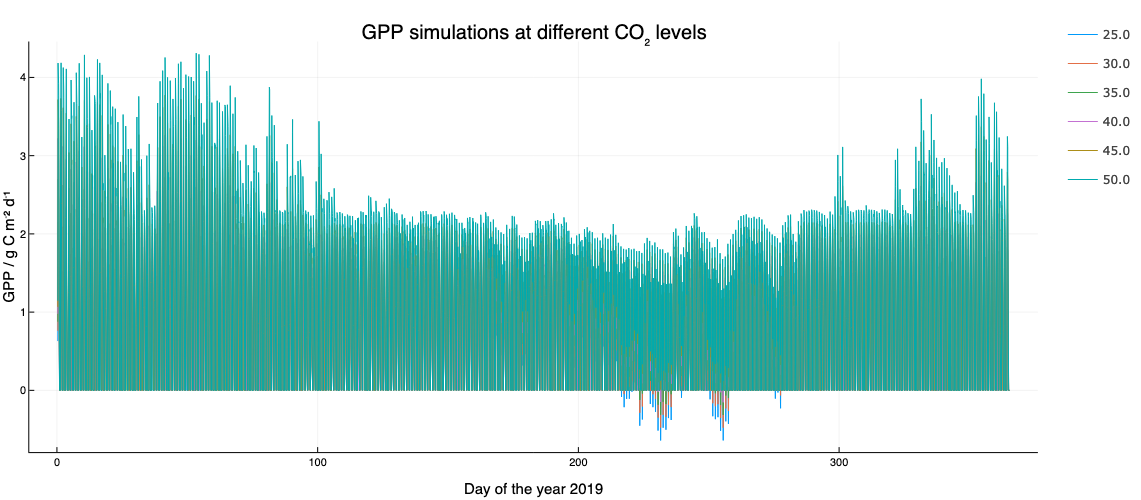

In [23]:
@df df StatsPlots.plot(:FDOY, :F_GPP, group = :CO2,
        size=(1000, 500),
        xlabel="Day of the year 2019",
        ylabel="GPP / g C m⁻² d⁻¹",
        title="GPP simulations at different CO₂ levels")

What we observe is somehow expected and biologically interpretible: With elevated CO₂ concentration the GPP also increases. Nonetheless, the negative GPP values are somehow strange ... As they occur in summer, it is probably a result of the stomatal response. Still, I would need to read into if that could be explained by a biological phenomenon.

---
# References
[**Dai Y, Xin Q, Wei N, Zhang Y, Shangguan W, Yuan H, Zhang S, Liu S, Lu X. 2019.**](https://doi.org/10.1029/2019MS001784) <a id="daiGlobalHighResolutionData2019"></a> A Global High-Resolution Data Set of Soil Hydraulic and Thermal Properties for Land Surface Modeling. Journal of Advances in Modeling Earth Systems 11: 2996–3023.

[**van Genuchten MTh. 1980.**](https://doi.org/10.2136/sssaj1980.03615995004400050002x) <a id="vangenuchtenClosedformEquationPredicting1980"></a> A Closed-form Equation for Predicting the Hydraulic Conductivity of Unsaturated Soils. Soil Science Society of America Journal 44: 892–898.

[**Wang Y, Braghiere RK, Longo M, Norton A, Köhler P, Doughty R, Yin Y, Bloom AA, Frankenberg C. 2022.**](https://doi.org/10.1002/essoar.10509956.1) <a id="wangModelingGlobalCarbon2022a"></a> Modeling global carbon and water fluxes and hyperspectral canopy radiative transfer simultaneously using a next generation land surface model—CliMA Land. Biological Sciences.
